In [1]:
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
import os
import random
import re
import time
import json
import wandb
import pickle

from matplotlib import pyplot as plt
from glob import glob
from PIL import Image
from tqdm import tqdm

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
wandb.login()

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize
wandb: ERROR Can't accept input in this environment, you should set WANDB_API_KEY or call wandb.login(key='YOUR_API_KEY')


False

In [3]:
df_captions = pd.read_csv('../input/flickr-image-dataset/flickr30k_images/results.csv', delimiter='|')

In [4]:
df_captions.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [5]:
df_captions.columns = ['image_name', 'comment_number', 'comment']

In [6]:
df_captions['comment_new'] = df_captions['comment'].progress_apply(lambda x : '<start> ' + str(x) + ' <end>')

100%|██████████| 158915/158915 [00:00<00:00, 432722.64it/s]


In [7]:
path = '../input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
df_captions['image_name_new'] = df_captions['image_name'].progress_apply(lambda x : path + x)

100%|██████████| 158915/158915 [00:00<00:00, 492079.43it/s]


In [8]:
df_captions.head()

,image_name,comment_number,comment,comment_new,image_name_new
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,<start> Two young guys with shaggy hair look ...,../input/flickr-image-dataset/flickr30k_images...
1,1000092795.jpg,1,"Two young , White males are outside near many...","<start> Two young , White males are outside n...",../input/flickr-image-dataset/flickr30k_images...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,<start> Two men in green shirts are standing ...,../input/flickr-image-dataset/flickr30k_images...
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,<start> A man in a blue shirt standing in a g...,../input/flickr-image-dataset/flickr30k_images...
4,1000092795.jpg,4,Two friends enjoy time spent together .,<start> Two friends enjoy time spent together...,../input/flickr-image-dataset/flickr30k_images...


In [9]:
all_img_name_vector =  df_captions['image_name_new'].tolist()
all_captions = df_captions['comment_new'].tolist()

In [10]:
# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [11]:
train_captions[0],img_name_vector[0]

('<start>  A legless man is walking next to a man in a bright yellow shirt . <end>',
 '../input/flickr-image-dataset/flickr30k_images/flickr30k_images/6321643151.jpg')

In [12]:
# Select the first 30000 captions from the shuffled set
num_examples = 10000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [13]:
len(train_captions), len(all_captions)

(10000, 158915)

### Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:

Resizing the image to 299px by 299px
Preprocess the images using the preprocess_input method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [14]:
def load_image(image_path,cap):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, cap

+ Initialize InceptionV3 and load the pretrained Imagenet weights

+ Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is 8x8x2048. You use the last convolutional layer because you are using attention in this example. 

+ You don't perform this initialization during training because it could become a bottleneck.

+ You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).

+ After all the images are passed through the network, you pickle the dictionary and save it to disk.

### Preprocess and tokenize the captions

+ First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).

+ Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).

+ You then create word-to-index and index-to-word mappings.

+ Finally, you pad all sequences to be the same length as the longest one.

In [15]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [16]:
# Choose the top 5000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [17]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [18]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [19]:
# Pad each vector to the max_length of the captions

# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [20]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

62

#### Split the data into training and testing

In [21]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)


In [22]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(8000, 8000, 2000, 2000)

### Create a tf.data dataset for training

Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [23]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 128
BUFFER_SIZE = 1000
embedding_dim = 100
units = 256
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [24]:
# # Load the numpy files
# def map_func(img_name, cap):
#     img_tensor = np.load(img_name.decode('utf-8')+'.npy')
#     return img_tensor, cap

In [25]:
img_name_train[0]

'../input/flickr-image-dataset/flickr30k_images/flickr30k_images/2511794705.jpg'

In [26]:
#Preparing the tf dataset
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# # Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          load_image, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls = tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Model
+ The decoder below is identical to the one in the example for Neural Machine Translation with Attention.

+ The model architecture is inspired by the Show, Attend and Tell paper.

+ In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).

+ You squash that to a shape of (64, 2048).

+ This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).

+ The RNN (here GRU) attends over the image to predict the next word.

In [27]:
class BahdanauAttention(tf.keras.Model):
    
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [28]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

87916544/87910968 [==============================] - 2s 0us/step


### Encoder Network

In [29]:
class CNN_Encoder(tf.keras.Model):
    
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
        
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.image_features_extract_model(x)    #shape batch_sz * 8 * 8 * 2048
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))  #shape batch_sz * 64 * 2048
        x = self.fc(x)     ##shape batch_sz * 64 * embedding_dim
        x = tf.nn.relu(x)  ##shape batch_sz * 64 * embedding_dim with relu
        return x

### Decoder Network

In [30]:
class RNN_Decoder(tf.keras.Model):  
    
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units     

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

        

    def call(self, x, features, hidden):

        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [31]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [32]:
#Optimizer
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Checkpoint

In [33]:
checkpoint_path = "/kaggle/working/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [34]:
start_epoch = 0

if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

### Training

+ You extract the features by passing the images through the encoder.

+ The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.

+ The decoder returns the predictions and the decoder hidden state.

+ The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.

+ Use teacher forcing to decide the next input to the decoder.

+ Teacher forcing is the technique where the target word is passed as the next input to the decoder.

+ The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [35]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [36]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    #Total loss for batchi
    total_loss = (loss / int(target.shape[1]))  #loss for batch_i per word


    #trainable_variables ????? -> Getting all th weights for the encoder and decoder for gradient descent
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    #Performing the gradient descent
    gradients = tape.gradient(loss, trainable_variables)
    
    #applying the optimization
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [37]:
### id is for run name
wandb.init(project="image-captioning", id="initial-run")

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize
wandb: ERROR Can't accept input in this environment, you should set WANDB_API_KEY or call wandb.login(key='YOUR_API_KEY')


wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Error: Can't find API key, run wandb login or set WANDB_API_KEY

In [38]:
EPOCHS = 100


for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    wandb.log({"loss": total_loss / num_steps})
    
    
    if epoch % 5 == 0:
        ckpt_manager.save()
    
    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    

    

Epoch 1 Batch 0 Loss 1.9233


wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1 Loss 1.350736
Time taken for 1 epoch 272.01242208480835 sec

Epoch 2 Batch 0 Loss 1.2290
Epoch 2 Loss 1.231870
Time taken for 1 epoch 110.4753987789154 sec

Epoch 3 Batch 0 Loss 1.2040
Epoch 3 Loss 1.229931
Time taken for 1 epoch 111.61562943458557 sec

Epoch 4 Batch 0 Loss 1.2644
Epoch 4 Loss 1.229338
Time taken for 1 epoch 110.47138857841492 sec

Epoch 5 Batch 0 Loss 1.2954
Epoch 5 Loss 1.227331
Time taken for 1 epoch 110.67935037612915 sec

Epoch 6 Batch 0 Loss 1.2302
Epoch 6 Loss 1.226623
Time taken for 1 epoch 111.2239294052124 sec

Epoch 7 Batch 0 Loss 1.1759
Epoch 7 Loss 1.225484
Time taken for 1 epoch 110.1174669265747 sec

Epoch 8 Batch 0 Loss 1.2342
Epoch 8 Loss 1.226100
Time taken for 1 epoch 109.49009132385254 sec

Epoch 9 Batch 0 Loss 1.2136
Epoch 9 Loss 1.225724
Time taken for 1 epoch 110.77115035057068 sec

Epoch 10 Batch 0 Loss 1.2571
Epoch 10 Loss 1.224396
Time taken for 1 epoch 110.42040777206421 sec

Epoch 11 Batch 0 Loss 1.2848
Epoch 11 Loss 1.225491
Time ta

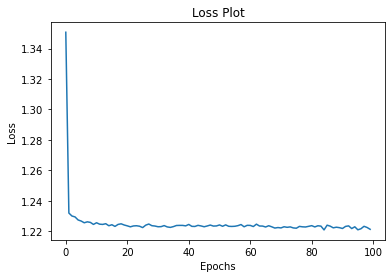

In [39]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [40]:
def evaluate(image):
    
    #Plotting the attention weights
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)
    
    #loading image with random caption
    img,_ = load_image(image,'')
    temp_input = tf.expand_dims(img, 0)
    
    #extracting image features
    features = encoder(temp_input)
    
    #dec imput
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [41]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a tan dog and a cream colored dog run through grasslands <end>
Prediction Caption: play kiss blue a black wearing <end>


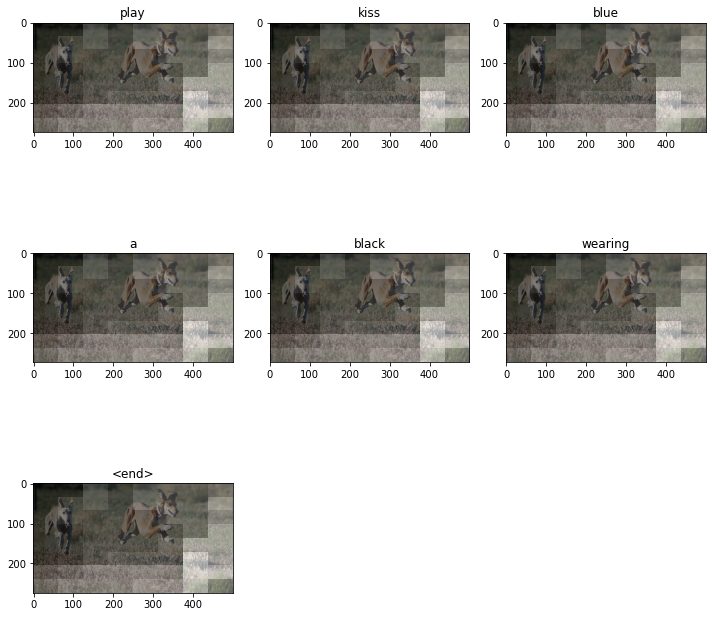

In [42]:

# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


In [ ]:
### include more data to get better captions for the image

In [43]:
# x = tf.random.normal(shape = (100,299,299,3))
# x.shape
# enc = CNN_Encoder(256)
# enc(x).shape